In [1]:
from nddho_generator import nddho_generator
import phaseco as pc
import matplotlib.pyplot as plt
from scipy.signal import correlate, get_window
from scipy.optimize import curve_fit
import numpy as np
from N_xi_fit_funcs import *

In [2]:
fs = 44100
wf_len_s = 60
gamma = 500
f_d = 1000

wf = nddho_generator(f_d, gamma=gamma, fs=fs, t_max=wf_len_s)[0]



100%|██████████| 2645999/2645999 [00:06<00:00, 411718.17it/s]


In [3]:
win_type = 'flattop'
tau = get_precalc_tau_from_bw(bw=400, fs=44100, win_type=win_type)
win = get_window(win_type, tau)
omega_0_norm = f_d * 2*np.pi / fs
kernel = win * np.exp(1j * omega_0_norm * np.arange(len(win)))
wf_filtered = np.convolve(wf, kernel)

In [7]:
tau = 2**15
print(tau)
f, psd = pc.get_welch(wf_filtered, fs, tau, realfft=False)

32768


In [5]:
# Get range
f_bound_width = 200
f_min = f_d - f_bound_width
f_max = f_d + f_bound_width
f_min_idx = np.argmin(np.abs(f-f_min))
f_max_idx = np.argmin(np.abs(f-f_max))
f_crop, psd_crop = f[f_min_idx:f_max_idx], psd[f_min_idx:f_max_idx]



In [6]:
import numpy as np
from scipy.optimize import curve_fit

# This increases without bound as the multiplier on the A bound increases... what the hell!

def fit_lorentzian(f, psd):
    """
    Fit a single Lorentzian to a PSD peak.

    Parameters
    ----------
    f : ndarray
        Frequency array.
    psd : ndarray
        PSD array corresponding to f.

    Returns
    -------
    popt : ndarray
        Optimal parameters [x0, hwhm, A].
    lorentz_fit : ndarray
        Lorentzian evaluated at f with fitted parameters.
    """
    # --- Lorentzian model ---
    def lorentzian(x, x0, hwhm, A):
        return A / (1 + ((x - x0) / hwhm)**2)
    
    # --- Initial guesses ---
    peak_idx = np.argmax(psd)
    x0_guess = f[peak_idx]
    A_guess = psd[peak_idx]
    
    # Rough HWHM estimate: find freq span where PSD > half max
    half_max = A_guess / 2
    indices_half = np.where(psd > half_max)[0]
    if len(indices_half) > 1:
        hwhm_guess = (f[indices_half[-1]] - f[indices_half[0]]) / 2
    else:
        hwhm_guess = (f[-1] - f[0]) / 10  # fallback guess
    
    p0 = [x0_guess, hwhm_guess, A_guess]
    
    # --- Bounds ---
    x0_bounds = (f[0], f[-1])
    hwhm_bounds = (0, f[-1] - f[0])
    A_bounds = (A_guess*0.5, A_guess*1.3) # PROBLEM
    
    bounds = ( [x0_bounds[0], hwhm_bounds[0], A_bounds[0]],
               [x0_bounds[1], hwhm_bounds[1], A_bounds[1]] )
    
    # --- Fit ---
    try:
        popt, pcov = curve_fit(lorentzian, f, psd, p0=p0, bounds=bounds)
    except RuntimeError:
        print("Lorentzian fit did not converge, returning initial guess.")
        popt = p0
    
    lorentz_fit = lorentzian(f, *popt)
    
    return popt, lorentz_fit

popt, lorentz_fit_crop = fit_lorentzian(f_crop, psd_crop)
print("Fitted parameters [x0, hwhm, A]:", popt)
print(f"Max PSD = [{np.max(psd)}]")

import matplotlib.pyplot as plt
plt.scatter(f_crop, psd_crop, label="PSD")
plt.plot(f_crop, lorentz_fit_crop, label="Lorentzian fit", color='red')
plt.legend()
plt.show()




c:\Users\setht\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\optimize\_lsq\least_squares.py:103: ComplexWarning: Casting complex values to real discards the imaginary part
  lb, ub = (np.asarray(b, dtype=float) for b in bounds)
c:\Users\setht\AppData\Local\Programs\Python\Python313\Lib\site-packages\numpy\lib\_function_base_impl.py:644: ComplexWarning: Casting complex values to real discards the imaginary part
  a = asarray(a, dtype=dtype, order=order)


ValueError: `x0` must be real.

(-100.0, 100.0)

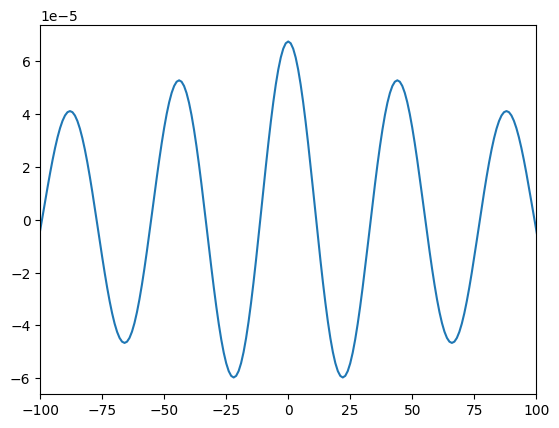

In [232]:
acf = correlate(wf, wf)
N = len(wf)
lags = np.arange(-(N-1), N)
plt.plot(lags, acf)
plt.xlim(-100, 100)

In [10]:
def func1(omega):
    gamma = 10
    D = 100
    omega_0 = 20
    omega_d = np.sqrt(omega_0**2-gamma**2 / 4)

    return 2*D / ((omega_0**2-omega**2)**2+(gamma*omega)**2)

def func2(omega):
    gamma = 10
    D = 100
    omega_0 = 20
    omega_d = np.sqrt(omega_0**2-gamma**2 / 4)

    return (D * gamma / (2 * omega_d**2)) * (1 / ((omega - omega_d)**2+(gamma / 2)**2) + 1 / ((omega + omega_d)**2+(gamma / 2)**2))

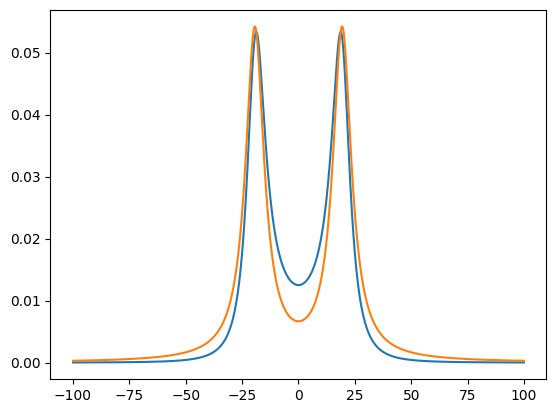

In [12]:
omega = np.linspace(-100, 100, 10000)
plt.plot(omega, func1(omega)*10)
plt.plot(omega, func2(omega))
plt.show()